# Partie 2 - Régression - Rendement du maïs

## Packages and Helpers

In [2]:
# NOT IN : 'FactoMineR', 'corrplot')
PACKAGES = c('caret', 'e1071', 'elasticnet', 'gam', 'glmnet', 'kernlab', 'MASS', 'pls', 'randomForest', 'rpart')
for (package in PACKAGES) {
	if (!require(package, character.only=TRUE)) {
		install.packages(package)
		if (!require(package, character.only=TRUE))
			stop(paste("Package", package, "not found"))
	}
}
options(repr.plot.width=9, repr.plot.height=5)

In [25]:
tryCatch({
    library(doParallel)
    if (exists('cluster')) {
        print("Closing cluster")
        stopCluster(cluster)
    }
    
    cluster = makePSOCKcluster(5)
    registerDoParallel(cluster)
    print("Cluster created")
})

[1] "Closing cluster"
[1] "Cluster created"


### Plot functions

In [3]:
# Color gradient generator
color.gradient <- function(x, colors=c("#00AFBB", "#E7B800", "#FC4E07"), colsteps=100) {
  return( colorRampPalette(colors) (colsteps) [ findInterval(x, seq(min(x), max(x), length.out=colsteps)) ] )
}

In [4]:
# Pairs plot
CORR_GRAD = colorRampPalette(c('black', 'yellow', 'red'))(100)
pairs.corr = function(x, y) {
    usr = par("usr"); on.exit(par(usr))
    par(usr = c(0, 1, 0, 1))
    r = round(cor(x, y), digits=2)
    txt = paste0("R = ", r)
    text(0.5, 0.5, txt, cex = (1 + abs(r)), col=CORR_GRAD[round(abs(r)*100)])
}
    
pairs.scatter = function(x, y) {
    points(x, y, col=rgb(0,0,0,0.2))
}

In [7]:
# Intervals plot
plot_interval = function(x, lower, upper) {
    sorted = sort(x, index.return=TRUE)
    polygon(c(sorted$x, rev(sorted$x)),
            c(lower[sorted$ix], upper[rev(sorted$ix)]),
            col = rgb(0, 0.1, 1, 0.05),
            border= rgb(0, 0.1, 1, 0.5))
#     arrows(x, upper, x, lower, angle=90, tcode=3, length=0.1)
}

plot_pred_interval = function(interval, y_true, y_pred, main="Interval") {
    x = interval[,1]
    lower = interval[,2]
    upper = interval[,3]

    idx.obs.out = which((y_true < lower) | (y_true > upper))
    idx.pred.out = which((y_pred < lower) | (y_pred > upper))

    # Plot observations
    plot(x[-idx.obs.out],  y_true[-idx.obs.out], pch=1, col='blue',
         ylim=range(interval, y_true, y_pred),
         main=main, xlab='x', ylab='y interval')
    points(x[idx.obs.out], y_true[idx.obs.out],  pch=1, col='red')

    # Plot predictions
    points(x[-idx.pred.out], y_true[-idx.pred.out], pch=3, col='blue')
    points(x[idx.pred.out],   y_true[idx.pred.out], pch=3, col='red')
    
    # Plot interval and 0.1-line
    plot_interval(x, lower, upper)
    abline(0, 1)
}

plot_pred_intervals = function(model, data, ycols) {
    # Get observations and predictions
    y_true = data[,ycols]
    y_pred = predict(model, newdata=data)
    
    # Get intervals
    int_pred = predict(model, interval='prediction', newdata=data)
    int_conf = predict(model, interval='confidence', newdata=data)

    par(mfrow=c(1,2))
    plot_pred_interval(int_pred, y_true, y_pred, main="Prediction interval")
    plot_pred_interval(int_conf, y_true, y_pred, main="Confidence interval")
}

In [8]:
## QQ Normality plot
qq_plot = function(residuals) {
    qqnorm(residuals)
    qqline(residuals)
    print(shapiro.test(residuals))
}

In [9]:
# Predictions / expectations plot
pred_true_plot = function(y_true, y_pred) {
    plot(y_true, y_pred, xlab="y_true", ylab="y_pred", main="Predictions vs Expectations")
    abline(0, 1, col="red")
}

In [10]:
# PCA Plot variance explained by components
plot_pca_var = function(pca, coeffs = c(90, 95)) {
    n = length(coeffs)
    cmap = heat.colors(n)
    eig = pca$eig[,3]
    plot(eig, type='l', xlab='components', ylab='cumulative percentage of variance')
    for (i in 1:n) {
        abline(h=coeffs[i], col=cmap[n-i+1])
        abline(v=which.min(abs(eig - coeffs[i])), col=cmap[n-i+1])
    }
}

In [11]:
# Studentized residuals plot
studentized_residuals_plot = function(y_true, residuals, threshold=2) {
    plot(y_true, residuals,
         main="Studentized Residuals",
         ylab="rstandard",
         col=ifelse(abs(residuals)> threshold, 'red', 'black'))
    abline(h = -threshold, col='red')
    abline(h = threshold, col='red')
}

In [12]:
# MSE Plot
mse_plot = function(y_true, y_pred) {
    squared_error = (y_true - y_pred)^2
    mse = mean(squared_error)
    plot(squared_error, ylab='squared error', main=paste('MSE', round(mse, digits=3)))
    abline(h=mse, col='red')    
}

### Metrics helpers

In [13]:
# Metrics
adjust_R2 = function(r2, k, p) {
    if (k == p)
        return(r2)
    else
        return(r2 - (k-1)/(p-k)*(1-r2))
}

## Exploration des données

> Semis en Avril et récolte en octobre/novembre

2300 individus et 58 variables

Variables:
- `yield_anomaly` (float): variable à prédire représentant l’anomalie de rendement de maïs (une valeur positive indique un rendement plus élevé
qu’attendu, une valeur négative indique une valeur perte de rendement par rapport à la valeur attendue), exprimée en tonne par ha.
- `year_harvest` (int): année (anonyme) de récolte (1 à 57)
- `NUMD` (int): numéro (anonyme) indiquant le département (de 1 à 94).
- `ETP_1`, ... ,`ETP_9` (float): Evapotranspiration potentielle moyenne mensuelle par année et par département (1= janvier, 9=septembre)
- `PR_1`, ... ,` PR_9` (float): Précipitation cumulée mensuelle par année et par
département (1= janvier, 9=septembre)
- `RV_1`, ... ,` RV_9` (float): Rayonnement moyen mensuel par année et par département (1= janvier, 9=septembre)
- `SeqPR1`, ... ,`SeqPR9` (float): Nombre de jours de pluie mensuel par année et
par département (1= janvier, 9=septembre)
- `Tn_1`, ... ,`Tn_9` (float): Température minimale journalière moyenne mensuelle par année et par département (1= janvier, 9=septembre)
- `Tx_1`, ... ,`Tx_9` (float): Température maximale journalière moyenne mensuelle par année et par département (1= janvier, 9=septembre)
- `IRR` (int): variable comprise entre 1 et 5 liée à la fraction de surface agricole irriguée dans chaque département. La valeur 1 indique une fraction faible, la valeur 5 indique une fraction élevée de surface irriguée.
Ces valeurs sont indicatives car établies sur la base d'information collectée pendant une seule année.

&nbsp;


Pour le prétraitement, nous allons:
1. chercher si des valeurs manquent
2. enlever les variables ayant une variabilitée faible
3. enlever les variables fortement corrélées

In [5]:
range_col = function(key, r=1:9) paste(key, r, sep='_')
range_cols = function(keys, r=1:9) {
    cols = c()
    for (key in keys)
        cols = c(cols, range_col(key, r))
    return(cols)
}

### Chargement des données maïs

In [8]:
# Load data
mais.raw = read.csv('./data/mais_train.csv')
mais.raw$X = NULL

mais = mais.raw
# TODO Categorical encoding ??
# mais$NUMD = as.factor(mais$NUMD)
# mais$IRR = as.factor(mais$IRR)
mais.pre = mais

n = nrow(mais)
p = ncol(mais)

cat(n, 'x', p)
head(mais)

2300 x 58

year_harvest,yield_anomaly,NUMD,IRR,ETP_1,ETP_2,ETP_3,ETP_4,ETP_5,ETP_6,⋯,Tn_9,Tx_1,Tx_2,Tx_3,Tx_4,Tx_5,Tx_6,Tx_7,Tx_8,Tx_9
50,0.1825038,16,3,0.682472,1.293110,1.699620,2.44748,3.14399,4.20854,⋯,9.26988,10.123400,13.16220,10.75830,13.9877,19.9540,22.4562,24.2189,23.6961,20.1262
33,-0.3845784,83,3,0.432387,0.623810,1.431020,2.39696,3.13113,2.94998,⋯,10.96170,5.252540,2.59379,12.21890,12.6402,13.7359,16.0640,21.3142,23.6133,21.0558
57,-3.1240055,64,1,0.284586,0.478381,1.204350,2.30868,2.48770,3.61130,⋯,9.33011,4.216180,4.53739,10.12610,14.7061,17.2825,22.0111,26.6244,25.4657,17.2345
23,0.3425881,50,3,0.304020,0.426170,0.780732,1.71382,1.85480,3.44557,⋯,10.39020,0.150477,1.89350,9.13836,12.9452,14.1650,18.9474,19.8015,21.7915,18.0109
35,1.3362104,30,5,0.298557,0.459541,1.450150,1.88462,2.54718,3.47661,⋯,9.49472,8.157450,4.14919,10.93550,14.4118,17.2658,20.9065,20.9661,22.6803,17.8078
37,1.2148426,36,3,0.978619,0.916539,1.822910,2.07887,2.93823,3.76420,⋯,12.53060,8.603350,12.48080,11.72800,14.4203,17.7080,20.8284,26.4588,24.4734,20.0928


Les données `ETP`, `PR`, `RV`, `SeqPR`, `Tn` et `Tx` correspondent à des mesures dans le temps, sur les 9 premiers mois de l'année de la récolte. Elles sont donc très sûrement corrélées entre elles.

In [9]:
# Summary of data
cat("Missing values:", sum(is.na(mais.pre)))
cat("\nData summary:")
# summary(mais)

Missing values: 0
Data summary:

Aucune donnée ne manque. Les données n'ont pas l'air d'avoir de valeurs aberrantes.

In [10]:
count.unique = function(x) {
    n = length(unique(x))
    return(c(n, n / length(x)))
}
unique_freq = t(apply(mais, MARGIN=2, FUN=count.unique))
colnames(unique_freq) = c('n_unique', 'freq')
unique_freq

,n_unique,freq
year_harvest,38,0.016521739
yield_anomaly,2299,0.999565217
NUMD,94,0.040869565
IRR,5,0.002173913
ETP_1,2296,0.998260870
ETP_2,2295,0.997826087
ETP_3,2284,0.993043478
ETP_4,2285,0.993478261
ETP_5,2287,0.994347826
ETP_6,2289,0.995217391


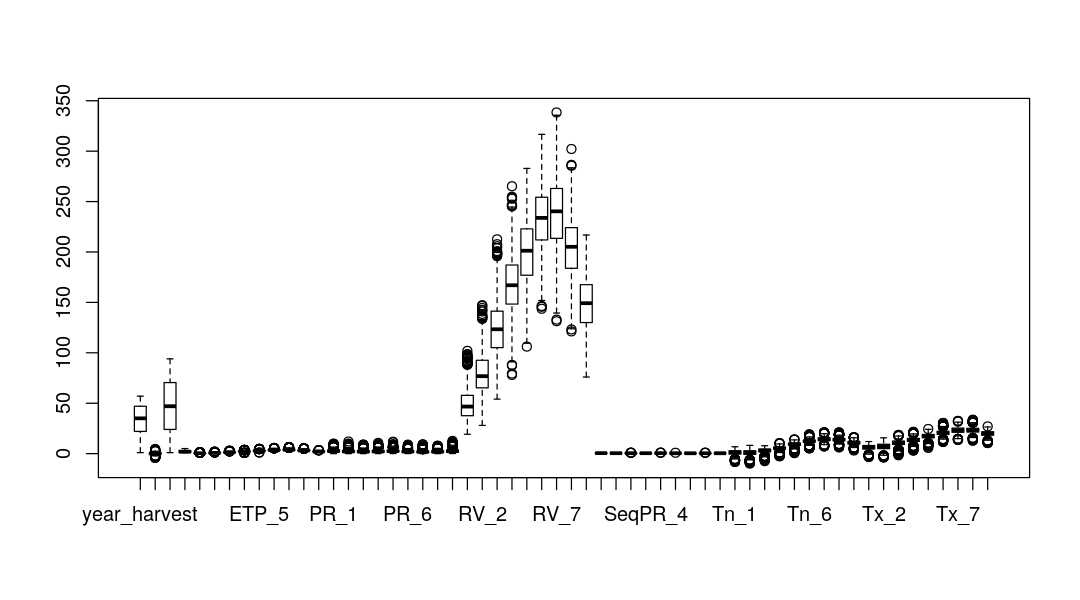

In [29]:
# boxplot(subset(mais, select = -c(year_harvest, NUMD, IRR, 23:31)))
boxplot(mais.pre)

### Variabilité des variables

In [16]:
varvar = sort(apply(mais.pre, MARGIN = 2, function(col) sd(col)), decreasing = TRUE)
low_var = varvar < 0.5
cat("Variabilité basse:\n-", paste(names(varvar)[low_var], round(varvar[low_var], digits=3), sep=':\t', collapse='\n- '))

# plot(varvar, log='y')
# axis(1, at=1:length(varvar), labels=names(varvar))

Variabilité basse:
- ETP_4:	0.464
- ETP_9:	0.44
- ETP_3:	0.361
- ETP_2:	0.234
- SeqPR_2:	0.189
- SeqPR_4:	0.185
- SeqPR_1:	0.18
- ETP_1:	0.175
- SeqPR_3:	0.168
- SeqPR_9:	0.161
- SeqPR_8:	0.16
- SeqPR_6:	0.158
- SeqPR_7:	0.157
- SeqPR_5:	0.156

In [17]:
nzv = nearZeroVar(mais.pre, saveMetrics=TRUE)
nzv

,freqRatio,percentUnique,zeroVar,nzv
year_harvest,1.000000,1.6521739,FALSE,FALSE
yield_anomaly,2.000000,99.9565217,FALSE,FALSE
NUMD,1.032258,4.0869565,FALSE,FALSE
IRR,1.026359,0.2173913,FALSE,FALSE
ETP_1,1.000000,99.8260870,FALSE,FALSE
ETP_2,1.000000,99.7826087,FALSE,FALSE
ETP_3,1.000000,99.3043478,FALSE,FALSE
ETP_4,1.000000,99.3478261,FALSE,FALSE
ETP_5,1.000000,99.4347826,FALSE,FALSE
ETP_6,1.000000,99.5217391,FALSE,FALSE


On s'aperçoit qu'il n'y a pas de variables ayant une variance quasi nulle.

### Corrélation entre les variables

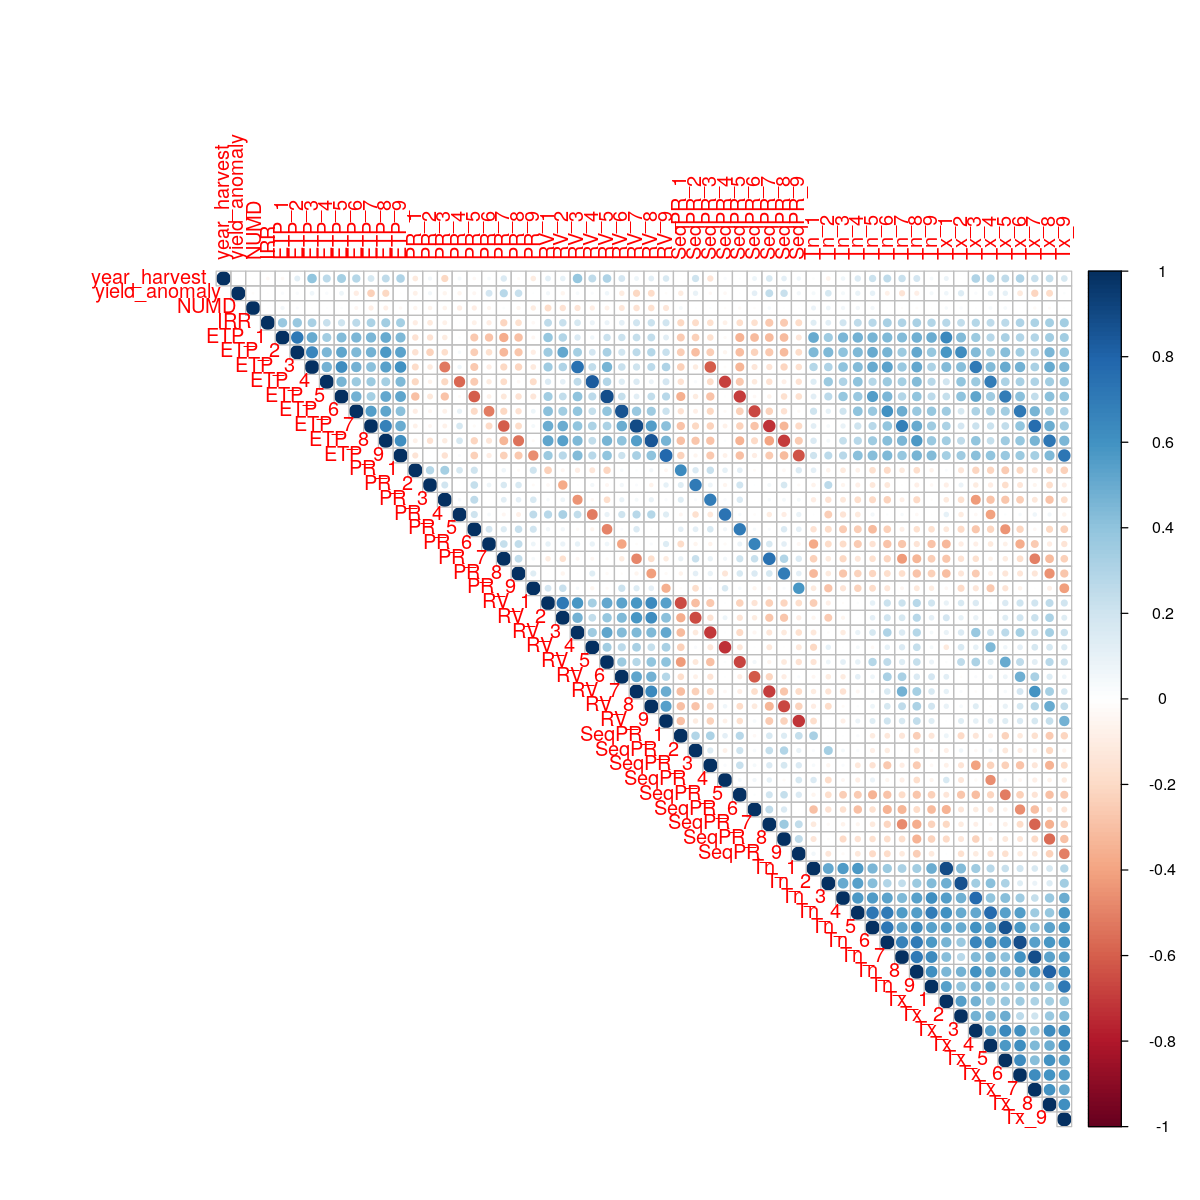

In [9]:
mais.raw.corr = cor(mais.raw)

options(repr.plot.width=10, repr.plot.height=10)
corrplot(mais.raw.corr, type="upper")
options(repr.plot.width=9, repr.plot.height=5)

In [10]:
# Take variables 2 by 2 and if correlation is high, only keep one
corr_cols = findCorrelation(mais.raw.corr, cutoff = 0.75)
print(colnames(mais.pre)[corr_cols])

 [1] "ETP_8" "Tn_8"  "Tn_6"  "ETP_9" "ETP_7" "Tn_5"  "Tn_7"  "ETP_5" "Tx_3" 
[10] "ETP_6" "Tn_4"  "ETP_4" "Tx_1"  "Tx_2" 


On observe:
- pas de corrélation suffisante entre la variable à prédire `yield_anomaly` et les variables explicatives.
- une corrélation relativement basse ( en valeur absolue en moyenne) entre `yield_anomaly` et `ETP_i`, `PR_i`, `RV_i` et `SeqPR_i`; et une corrélation faible pour `Tn_i` et `Tx_i` avec `i`$\in [[6,8]]$
- une corrélation forte dans les groupes de variables `ETP`, `RV`, `Tn` et `TX`.

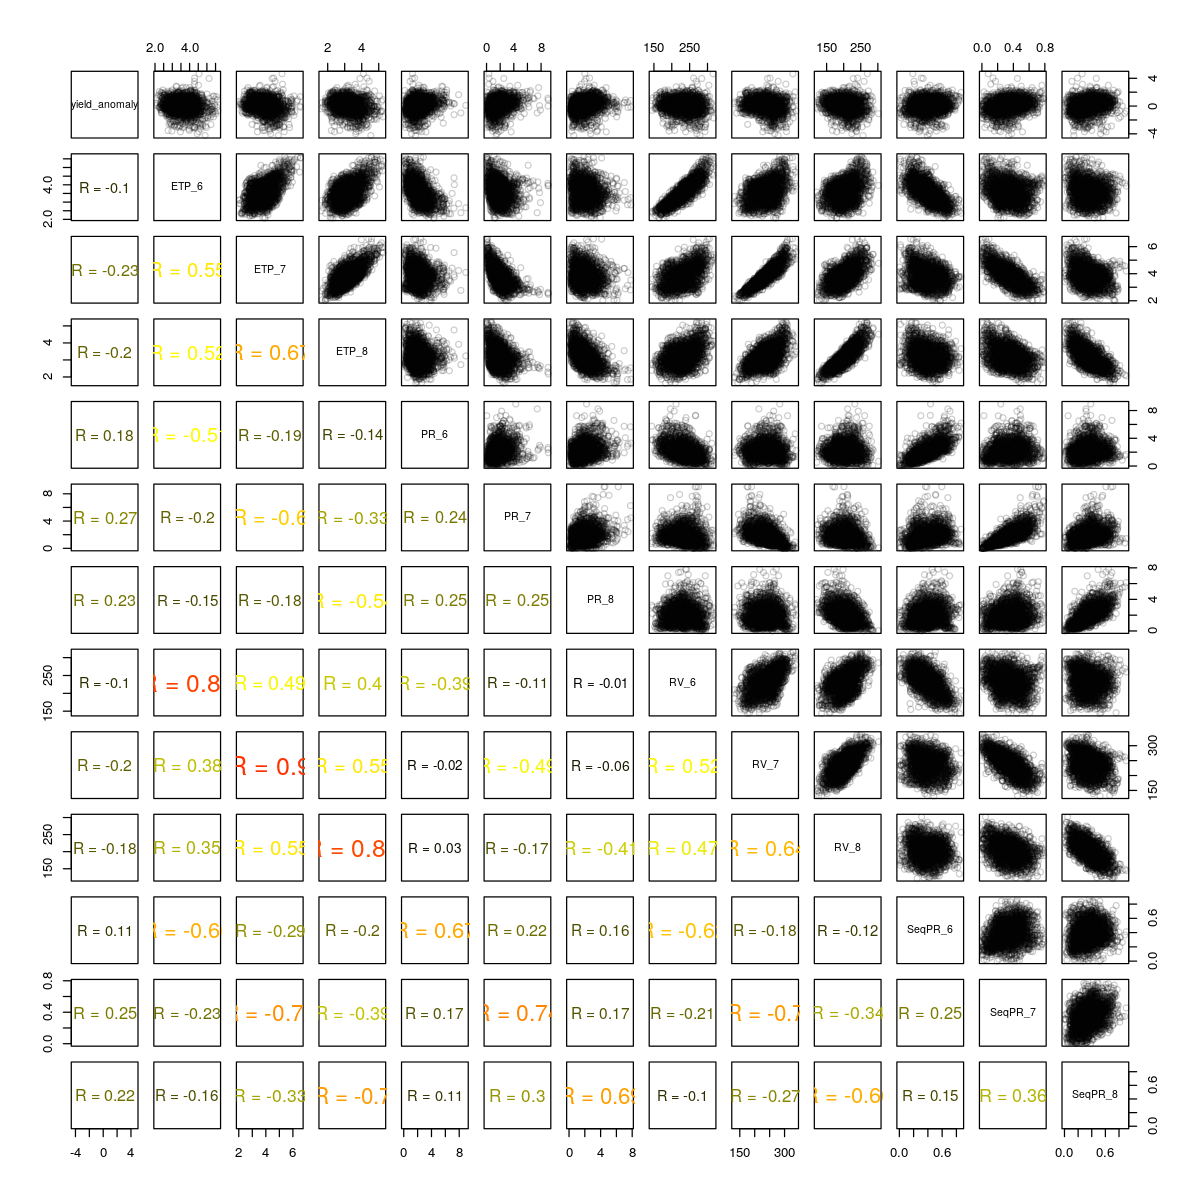

In [25]:
# TODO utile ?
cols = c('yield_anomaly', range_cols(c('ETP', 'PR', 'RV', 'SeqPR'), 6:8))

options(repr.plot.width=10, repr.plot.height=10)
pairs(mais.pre[, cols],
      lower.panel=pairs.corr,
      upper.panel=pairs.scatter)
options(repr.plot.width=9, repr.plot.height=5)

### Combinaisons linéaires

In [20]:
lin_combos = findLinearCombos(mais.pre)
lin_combos

$linearCombos
list()

$remove
NULL

Il n'y a pas de combinaisons linéaires.

### PCA

In [26]:
# PCA Plot variance explained by components
mais.pca = PCA(mais.raw)
plot_pca_var(mais.pca)

ERROR: Error in plot_pca_var(mais.pca): could not find function "plot_pca_var"


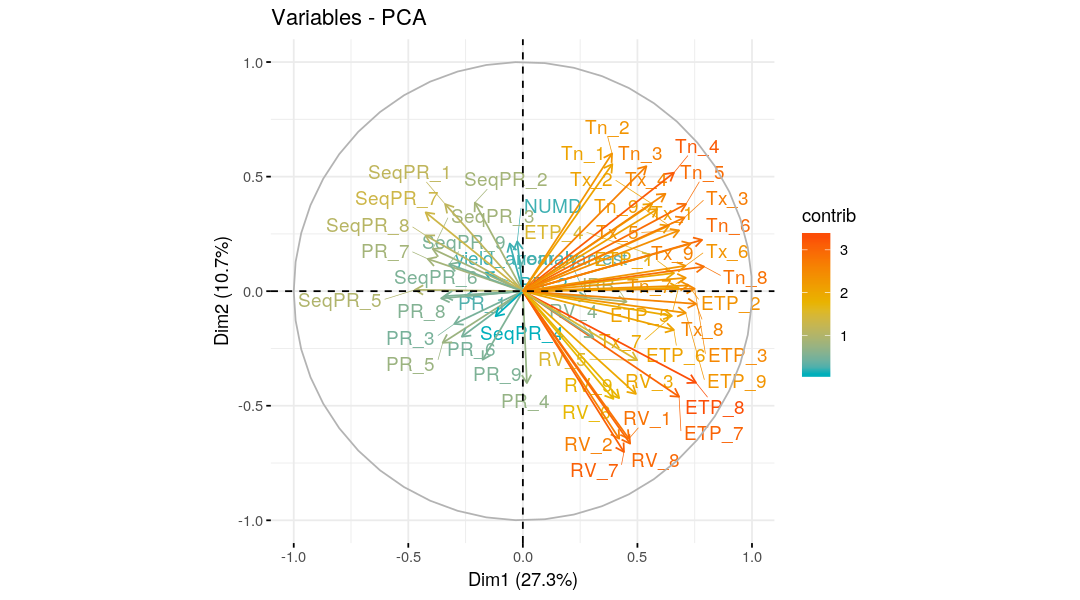

In [27]:
fviz_pca_var(mais.pca,
             col.var = "contrib",
             gradient.cols = c("#00AFBB", "#E7B800", "#FC4E07"),
             repel = TRUE)

### Prétraitement

In [11]:
# Remove correlated columns
mais = mais.pre[, -corr_cols]
print(dim(mais))

[1] 2300   44


## Exploration des modèles

### TEST Get all models

In [22]:
AUTH_LIBS = c(
	'jpeg', 'bestglm', 'e1071', 'FNN', 'MASS', 'pls', 'glmnet', 'klaR', 'caret', 'elasticnet',
	'LiblineaR', 'randomForest', 'ranger', 'mlbench', 'DT', 'rpart', 'tree', 'kernlab', 'keras', 'dplyr',
	'fastDummies', 'EBImage', 'imager', 'nnet', 'OpenImageR', 'reticulate', 'stringr', 'pbapply', 'mixtools', 'knitr',
	'plyr', 'mclust', 'gam', 'BiocManager', 'imager', 'OpenImageR'
)

In [23]:
models = list()
all_models = getModelInfo()

for (key in names(all_models)) {
    model = all_models[[key]]
    if ('Regression' %in% model$type && (is.null(model$library) || model$library %in% AUTH_LIBS))
        models[[key]] = model
}
length(models)

[1] 51

In [31]:
models_df = data.frame(matrix(ncol=4))
names(models_df) = c('Name', 'Method', 'Package', 'Params')
ifnone = function(val) ifelse(!is.null(val) && val != '', val, 'NONE')

for (key in names(models)) {
    model = models[[key]]
    param_str = paste(model$parameters$parameter, model$parameters$label, sep=': ', collapse = ' // ')
    models_df = rbind(models_df, c(model$label, key, ifnone(model$library), ifnone(param_str)))
}
models_df = models_df[-1,]
models_df

,Name,Method,Package,Params
2,Model Averaged Neural Network,avNNet,nnet,size: #Hidden Units // decay: Weight Decay // bag: Bagging
3,Bagged Model,bag,caret,vars: #Randomly Selected Predictors
4,Elasticnet,enet,elasticnet,fraction: Fraction of Full Solution // lambda: Weight Decay
5,Generalized Additive Model using LOESS,gamLoess,gam,span: Span // degree: Degree
6,Generalized Additive Model using Splines,gamSpline,gam,df: Degrees of Freedom
7,Gaussian Process,gaussprLinear,kernlab,parameter: Parameter
8,Gaussian Process with Polynomial Kernel,gaussprPoly,kernlab,degree: Polynomial Degree // scale: Scale
9,Gaussian Process with Radial Basis Function Kernel,gaussprRadial,kernlab,sigma: Sigma
10,Negative Binomial Generalized Linear Model,glm.nb,MASS,link: Link Function
11,Generalized Linear Model,glm,NONE,parameter: parameter


| ? | Name |                                                       Method |             Package |       Params |
| -----------------------------------------------------------: | :------------------ | :----------- | ------------------------------------------------------------ | :----------------------------------------------------------- |
|                                 |                                Model Averaged Neural Network |              avNNet |         nnet | `size`: #Hidden Units<br>`decay`: Weight Decay<br>`bag`: Bagging   |
|                                                  |                                                 Bagged Model |                 bag |        caret | `vars`: #Randomly Selected Predictors                          |
|                                                    |                                                   Elasticnet |                enet |   elasticnet | `fraction`: Fraction of Full Solution<br>`lambda`: Weight Decay  |
|                        |                       Generalized Additive Model using LOESS |            gamLoess |          gam | `span`: Span<br>`degree`: Degree                                 |
|                      |                     Generalized Additive Model using Splines |           gamSpline |          gam | `df`: Degrees of Freedom                                       |
|                                              |                                             Gaussian Process |       gaussprLinear |      kernlab | `parameter`: Parameter                                         |
|                       |                      Gaussian Process with Polynomial Kernel |         gaussprPoly |      kernlab | `degree`: Polynomial Degree<br>`scale`: Scale                    |
|            |           Gaussian Process with Radial Basis Function Kernel |       gaussprRadial |      kernlab | `sigma`: Sigma                                                 |
|                    |                   Negative Binomial Generalized Linear Model |              glm.nb |         MASS | `link`: Link Function                                          |
|                                      |                                     Generalized Linear Model |                 glm |         NONE | `parameter`: parameter                                         |
|                              |                             Boosted Generalized Linear Model |            glmboost |         plyr | `mstop`: # Boosting Iterations<br>`prune`: AIC Prune?            |
|                                                        |                                                       glmnet |              glmnet |       glmnet | `alpha`: Mixing Percentage<br>`lambda`: Regularization Parameter |
|      |     Generalized Linear Model with Stepwise Feature Selection |          glmStepAIC |         MASS | `parameter`: parameter                                         |
|                                         |                                        Partial Least Squares |           kernelpls |          pls | `ncomp`: #Components                                           |
|                                           |                                          k-Nearest Neighbors |                 knn |         NONE | `k`: #Neighbors                                                |
|                                                     |                                                    The lasso |               lasso |   elasticnet | `fraction`: Fraction of Full Solution                          |
|                                             |                                            Linear Regression |                  lm |         NONE | `intercept`: intercept                                         |
|                     |                    Linear Regression with Stepwise Selection |           lmStepAIC |         MASS | `parameter`: parameter                                         |
|               |              Multilayer Perceptron Network with Weight Decay |       mlpKerasDecay |        keras | `size`: #Hidden Units<br>`lambda`: L2 Regularization<br>`batch_size`: Batch Size<br>`lr`: Learning Rate<br>`rho`: Rho<br>`decay`: Learning Rate Decay<br>`activation`: Activation Function |
|                    |                   Multilayer Perceptron Network with Dropout |     mlpKerasDropout |        keras | `size`: #Hidden Units<br>`dropout`: Dropout Rate<br>`batch_size`: Batch Size<br>`lr`: Learning Rate<br>`rho`: Rho<br>`decay`: Learning Rate Decay<br>`activation`: Activation Function |
|                                                |                                               Neural Network |                nnet |         nnet | `size`: #Hidden Units<br>`decay`: Weight Decay                   |
|                                         |                                        Non-Informative Model |                null |         NONE | `parameter`: parameter                                         |
|                                        |                                       Parallel Random Forest |               parRF |        e1071 | `mtry`: #Randomly Selected Predictors                          |
|                       |                      Neural Networks with Feature Extraction |             pcaNNet |         nnet | `size`: #Hidden Units<br>`decay`: Weight Decay                   |
|                                  |                                 Principal Component Analysis |                 pcr |          pls | `ncomp`: #Components                                           |
|                                         |                                        Partial Least Squares |                 pls |          pls | `ncomp`: #Components                                           |
|                                 |                                Projection Pursuit Regression |                 ppr |         NONE | `nterms`: # Terms                                              |
|                                                 |                                                Random Forest |              ranger |        e1071 | `mtry`: #Randomly Selected Predictors<br>`splitrule`: Splitting Rule<br>min.node.`size`: Minimal Node Size |
|                                                 |                                                Random Forest |                  rf | randomForest | `mtry`: #Randomly Selected Predictors                          |
|                                |                               Random Forest Rule-Based Model |             rfRules | randomForest | `mtry`: #Randomly Selected Predictors<br>`maxdepth`: Maximum Rule Depth |
|                                              |                                             Ridge Regression |               ridge |   elasticnet | `lambda`: Weight Decay                                         |
|                                           |                                          Robust Linear Model |                 rlm |         MASS | `intercept`: intercept<br>`psi`: psi                             |
|                                                          |                                                         CART |               rpart |        rpart | `cp`: Complexity Parameter                                     |
|                                                          |                                                         CART |            rpart1SE |        rpart | `parameter`: parameter                                         |
|                                                          |                                                         CART |              rpart2 |        rpart | `maxdepth`: Max Tree Depth                                     |
|                                     |                                    Regularized Random Forest |                 RRF | randomForest | `mtry`: #Randomly Selected Predictors<br>`coefReg`: Regularization Value<br>`coefImp`: Importance Coefficient |
|                  |                 Relevance Vector Machines with Linear Kernel |           rvmLinear |      kernlab | `parameter`: parameter                                         |
|              |             Relevance Vector Machines with Polynomial Kernel |             rvmPoly |      kernlab | `scale`: Scale<br>`degree`: Polynomial Degree                    |
|   |  Relevance Vector Machines with Radial Basis Function Kernel |           rvmRadial |      kernlab | `sigma`: Sigma                                                 |
|                                         |                                        Partial Least Squares |              simpls |          pls | `ncomp`: #Components                                           |
|         |        Support Vector Machines with Boundrange String Kernel | svmBoundrangeString |      kernlab | `length`: length<br>`C`: Cost                                    |
|        |       Support Vector Machines with Exponential String Kernel |       svmExpoString |      kernlab | `lambda`: lambda<br>`C`: Cost                                    |
|                    |                   Support Vector Machines with Linear Kernel |           svmLinear |      kernlab | `C`: Cost                                                      |
|                    |                   Support Vector Machines with Linear Kernel |          svmLinear2 |        e1071 | `cost`: Cost                                                   |
|  | L2 Regularized Support Vector Machine (dual) with Linear Kernel |          svmLinear3 |    LiblineaR | `cost`: Cost<br>`Loss`: Loss Function                            |
|                |               Support Vector Machines with Polynomial Kernel |             svmPoly |      kernlab | `degree`: Polynomial Degree<br>`scale`: Scale<br>`C`: Cost         |
|     |    Support Vector Machines with Radial Basis Function Kernel |           svmRadial |      kernlab | `sigma`: Sigma<br>`C`: Cost                                      |
|     |    Support Vector Machines with Radial Basis Function Kernel |       svmRadialCost |      kernlab | `C`: Cost                                                      |
|     |    Support Vector Machines with Radial Basis Function Kernel |      svmRadialSigma |      kernlab | `sigma`: Sigma<br>`C`: Cost                                      |
|           |          Support Vector Machines with Spectrum String Kernel |   svmSpectrumString |      kernlab | `length`: length<br>`C`: Cost                                    |
|                                         |                                        Partial Least Squares |       widekernelpls |          pls | `ncomp`: #Components                                           |

### Méthode d'apprentissage

Avant tout nous séparons notre ensemble de données en:
- _train_ (80%): utilisé pour l'apprentissage des modèles
- _valid_ (20%): utilisé pour évaluer les modèles


La méthode `train` du package `caret` permet d'évaluer les performances d'un model rapidement et simplement.
Elle fonctione de la façon suivante:
- pour un modèle donné (par exemple `lm`)
- pour une grille de valeurs de paramètres à tester
    - pour chaque set de paramètres:
        - pour chaque échantillon _train_-_test_ de la validation croisée:
            - entrainer le modèle avec les paramètres sur _train_
            - évaluer ses performances avec diverses métriques sur _test_
    - calcul des performances moyennes du set de paramètres sur la validation croisée
- garder le meilleur set de paramètres (pour la régression, meilleur RMSE)
- rentrainer un modèle avec ce set sur toutes les données

Pour cette méthode `train`, nous utilisons une Validation Croisée à 10 plis des données _train_.

TOCHECK : yeojon et BoxCox => normalisation

In [12]:
# Training - validation split
valid.index = createDataPartition(mais$yield_anomaly, p=0.2, list=FALSE)
mais2 = as.data.frame(scale(mais, center = TRUE, scale = TRUE))
mais.train = mais2[-valid.index,]
mais.valid = mais2[valid.index,]
cat('(', nrow(mais.train), ',', nrow(mais.valid), ')', dim(mais))

# Get cross validation training control
trainingCV = trainControl(method="cv", number=10, allowParallel=TRUE)

( 1840 , 460 ) 2300 44

In [13]:
# Standard way to create train_model option
make_options = function(params, ...) c(list(params=params), list(...))

# Train one model with specified params
train_model = function(method, params = NULL, ...) {
    options = list(...)

    # First, add params to options
    if (is.list(params))
        options$tuneGrid = expand.grid(params)
    else if (is.numeric(params))
        options$tuneLength = params
    else if (!is.null(params))
        warning(paste("Unrecognized parameter type :", params))

    # Then, add constant options
    options = c(options, list(
        yield_anomaly ~ .,
        data = mais.train,
        trControl = trainingCV,
        method = method
    ))
    
    # Then, train and return model
    return(do.call(train, options))
}

In [ ]:
# TESSST
options = models.params$lm
options$method = 'lm'
do.call(train_model, options)

### Modèles à tester
Regression avec variables qualitatives
- Tree based model
- Random Forest
- Bagging
- Regression Mixture (em)
- Regression Qualitative (regression avec R)
- Regression Mixte
- SVM ??


- Stepwise regression
- [Rec feat elim](https://topepo.github.io/caret/recursive-feature-elimination.html)

In [39]:
# Try one model
n = 5
params = list(
    fraction = (1:n / n),
    lambda = (1:n / n)
)
# params = list(
#     mtry = nb Randomly Selected Predictors,
#     splitrule = Splitting Rule,
#     min.node.size = Minimal Node Size
# )
model = train_model('enet', params)
model

Elasticnet 

1840 samples
  43 predictor

No pre-processing
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 1656, 1656, 1656, 1656, 1656, 1656, ... 
Resampling results across tuning parameters:

  lambda  fraction  RMSE       Rsquared   MAE      
  0.1     0.1       0.9507030  0.1348051  0.7218022
  0.1     0.2       0.9249180  0.1681076  0.6962152
  0.1     0.3       0.9066009  0.1917082  0.6802385
  0.1     0.4       0.8937362  0.2080848  0.6702486
  0.1     0.5       0.8852846  0.2186639  0.6640180
  0.1     0.6       0.8780082  0.2296769  0.6586156
  0.1     0.7       0.8728771  0.2372185  0.6550404
  0.1     0.8       0.8700773  0.2413809  0.6533671
  0.1     0.9       0.8686880  0.2435823  0.6528421
  0.1     1.0       0.8678946  0.2450295  0.6529214
  0.2     0.1       0.9547917  0.1290053  0.7258239
  0.2     0.2       0.9303975  0.1590095  0.7010796
  0.2     0.3       0.9123524  0.1819349  0.6845347
  0.2     0.4       0.8999469  0.1975179  0.6747378
  0.2    

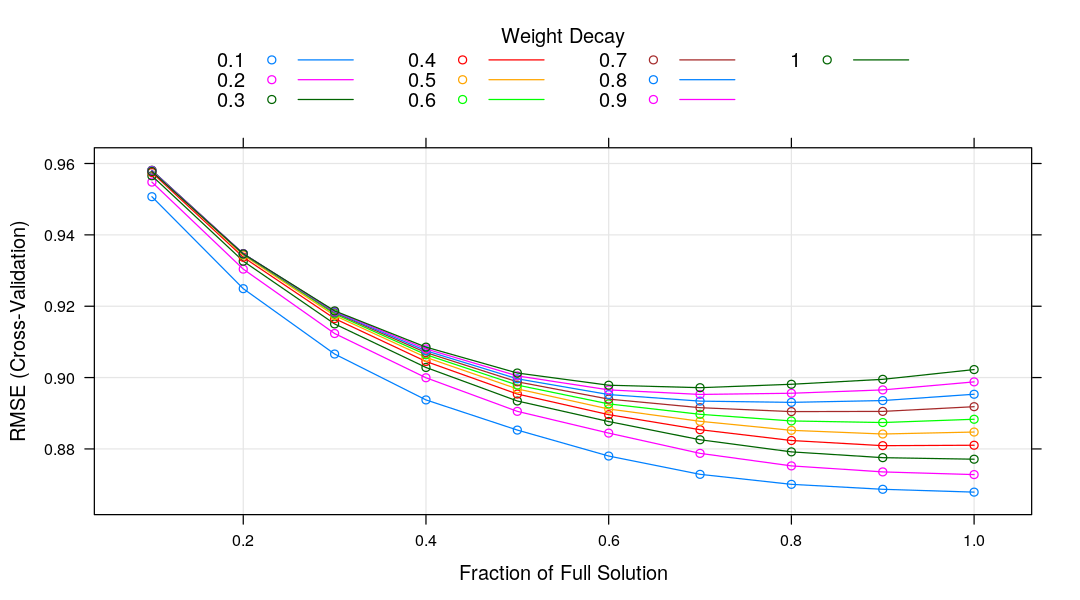

In [40]:
plot(model)

In [109]:
# Models params stores
models.store = list()
models.params = list(

    # ---------- Regressions ----------

    # Linear Regression
    lm = make_options(list(
        intercept=c(FALSE, TRUE)
    )),
    # Linear Regression with Stepwise Selection
    lmStepAIC = make_options(
        NULL,
        direction = 'forward',
        trace = FALSE
    ),
    
    # Partial Least Squares Regression
    pls = make_options(ncol(mais) - 1),
    # Principal Component Regression
    pcr = make_options(ncol(mais) - 1),

    # Ridge Regression
    ridge = make_options(6),
    # Lasso Regression
    lasso = make_options(11),
    # Elasticnet
    enet = make_options(5),

    # ---------- Tree based ----------

    # CART
    rpart = make_options(10),

    # Random Forest
    ranger = make_options(4),
#     list(
#         mtry = nb Randomly Selected Predictors,
#         splitrule = Splitting Rule,
#         min.node.size = Minimal Node Size
#     )),
    # Random Forest
    rf = make_options(6),

    # Regularized Random Forest
#     RRF = make_options(list(
#         mtry = nb Randomly Selected Predictors,
#         coefReg = Regularization Value,
#         coefImp = Importance Coefficient
#     )),

)
models.results = list()

In [ ]:
list(

    # ---------- Regressions ----------

    # Linear Regression
    lm = make_options(list(
        intercept = intercept
    )),

    # Linear Regression with Stepwise Selection
    lmStepAIC = make_options(list(
        parameter = parameter
    )),

    # Partial Least Squares Regression
    # TODO
    pls = make_options(list(
        ncomp = nb Components
    )),

    # Ridge Regression
    ridge = make_options(list(
        lambda = Weight Decay
    )),

    # Lasso Regression
    lasso = make_options(list(
        fraction = Fraction of Full Solution
    )),

    # Principal Component Regression
    pcr = make_options(list(
        ncomp = nb Components
    )),

    # ---------- Tree based ----------

    # CART
    rpart = make_options(list(
        cp = Complexity Parameter
    )),

    # Random Forest
    ranger = make_options(list(
        mtry = nb Randomly Selected Predictors,
        splitrule = Splitting Rule,
        min.node.size = Minimal Node Size
    )),

    # Random Forest
    rf = make_options(list(
        mtry = nb Randomly Selected Predictors
    )),

    # Regularized Random Forest
    RRF = make_options(list(
        mtry = nb Randomly Selected Predictors,
        coefReg = Regularization Value,
        coefImp = Importance Coefficient
    )),

    # ---------- GLM ----------

    # Generalized Additive Model using Splines
    gamSpline = make_options(list(
        df = Degrees of Freedom
    )),

    # Generalized Linear Model
    glm = make_options(list(
        parameter = parameter
    )),

    # Boosted Generalized Linear Model
    glmboost = make_options(list(
        mstop = nb Boosting Iterations,
        prune = AIC Prune?
    )),

    # glmnet
    glmnet = make_options(list(
        alpha = Mixing Percentage,
        lambda = Regularization Parameter
    )),

    # Generalized Linear Model with Stepwise Feature Selection
    glmStepAIC = make_options(list(
        parameter = parameter
    )),



    # ---------- SVM ----

    # Support Vector Machines with Linear Kernel
    svmLinear = make_options(list(
        C = Cost
    )),

    # Support Vector Machines with Polynomial Kernel
    svmPoly = make_options(list(
        degree = Polynomial Degree,
        scale = Scale,
        C = Cost
    )),

    # Support Vector Machines with Radial Basis Function Kernel
    svmRadial = make_options(list(
        sigma = Sigma,
        C = Cost
    )),

    # Support Vector Machines with Exponential String Kernel
    svmExpoString = make_options(list(
        lambda = lambda,
        C = Cost
    )),


    # ---------- Other ----------

    # k-Nearest Neighbors
    knn = make_options(list(
        k = nb Neighbors
    )),

    # Partial Least Squares
    widekernelpls = make_options(list(
        ncomp = nb Components
    )),

    # Partial Least Squares Kernel ???
    kernelpls = make_options(list(
        ncomp = nb Components
    )),

    # Partial Least Squares
    simpls = make_options(list(
        ncomp = nb Components
    )),

)


In [110]:
# Training loop
pb = txtProgressBar(min=0, max=length(models.params), initial=0, style=3)
i = 0

for (model in names(models.params)) {
    params = models.params[[model]]
    tryCatch({
        params$method = model
        models.store[[model]] = do.call(train_model, params)
    }, error=function(error) {
        cat("\nERROR with model", model, ": \n", error, "\n")
        models.store[[model]] = error
    })
    i = i + 1
    setTxtProgressBar(pb, i)
}

close(pb)
cat("\nDone !!")

  |======================================================================| 100%

Done !!

In [30]:
plot(model.lm)

ERROR: Error in plot.train(model.lm): There are no tuning parameters with more than 1 value.


## Evaluation des modèles

In [29]:
# Multiple plots
par(mfrow=c(2,2))
studentized_residuals_plot(mais.train$yield_anomaly, rstandard(mais.rl))
plot(0)
pred_true_plot(mais.train$yield_anomaly, fitted(mais.rl))
mse_plot(mais.train$yield_anomaly, fitted(mais.rl))